In [ ]:
# Example performance of HMM-based realignment:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys


[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files    = glob.glob('D:/T5_ClosedLoop/historical/*')
fig_path = 'C:/Users/ghwilson/Box/GuyWilson_Files/nonstationarities_project/paper_figures/figures/'

### train linear regression on day 0, get baseline performance measure


In [120]:
# Get initial day performance and decoder:
day0       = DataStruct(files[2], alignScreens = True)
train_size = 0.67
task       = None
blocks     = None
sigma      = None

train_x, test_x, train_y, test_y  = getTrainTest(day0, train_size = train_size, sigma = sigma, task = task, blocks = blocks, returnFlattened = True)
    
train_x, test_x         = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
train_y                 = np.concatenate(train_y)
test_y                  = np.concatenate(test_y)
#ef_decoder = LinearRegression(normalize = False).fit(train_x, train_y)
#ref_scores  = ref_decoder.score(test_x, test_y)
ref_scores, ref_decoder = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y])
 
print('Performance on day 0 with recalibration: R^2 = ', np.mean(ref_scores))

Performance on day 0 with recalibration: R^2 =  0.35389186205596873


In [121]:
# General parameters:
i          = 4  
train_frac = 0.67
task       = None


# HMM setup:
gridSize      = 20  
stayProb      = 0.999
vmKappa       = 4

#-----------------------------------------
file        = files[i]
new_dat     = DataStruct(file, alignScreens = True)

train_x, test_x, train_y, test_y, cursorPos, _  = getTrainTest(new_dat, train_size = train_size, sigma = sigma, task = task, blocks = blocks, 
                                                               returnFlattened = True, returnCursor = True)
train_x, test_x = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
train_y         = np.concatenate(train_y)
test_y          = np.concatenate(test_y)
cursorPos       = np.concatenate(cursorPos)

nStates         = gridSize**2
stateTrans      = np.eye(nStates)*stayProb #Define the state transition matrix, which assumes uniform transition probability of transitioning to new state
targLocs        = get_DiscreteTargetGrid(new_dat, gridSize = gridSize, task = task)

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-stayProb)/(nStates-1)
    
pStateStart = np.zeros((nStates,1)) + (1/nStates)
adjustKappa = lambda dist : 1 / (1 + np.exp(-1 * (dist - 70) * 0.5))

decoder   = deepcopy(ref_decoder)
neural    = [train_x]
cursorPos = [cursorPos]

hmm = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa, adjustKappa)

In [122]:
n_trials               = len(neural)
targStates, pTargState = list(), list()

neural_flattened       = np.concatenate(neural)
cursorPos_flattened    = np.concatenate(cursorPos)

for i in range(n_trials):
    rawDecTraj = ref_decoder.predict(neural[i] - neural_flattened.mean(axis = 0))
    targs      = hmm.viterbi_search(rawDecTraj, cursorPos[0])[0]
    pTargs     = hmm.decode(rawDecTraj, cursorPos[0])[0]
    targStates.append(targs)
    pTargState.append(pTargs)

targStates  = np.concatenate(targStates)
pTargState  = np.concatenate(pTargState)

maxProb         = np.max(pTargState, axis = 0)           # get P(H_i | O_1, ...., O_n)
inferredTargLoc = targLocs[targStates.astype('int').flatten(), :] 

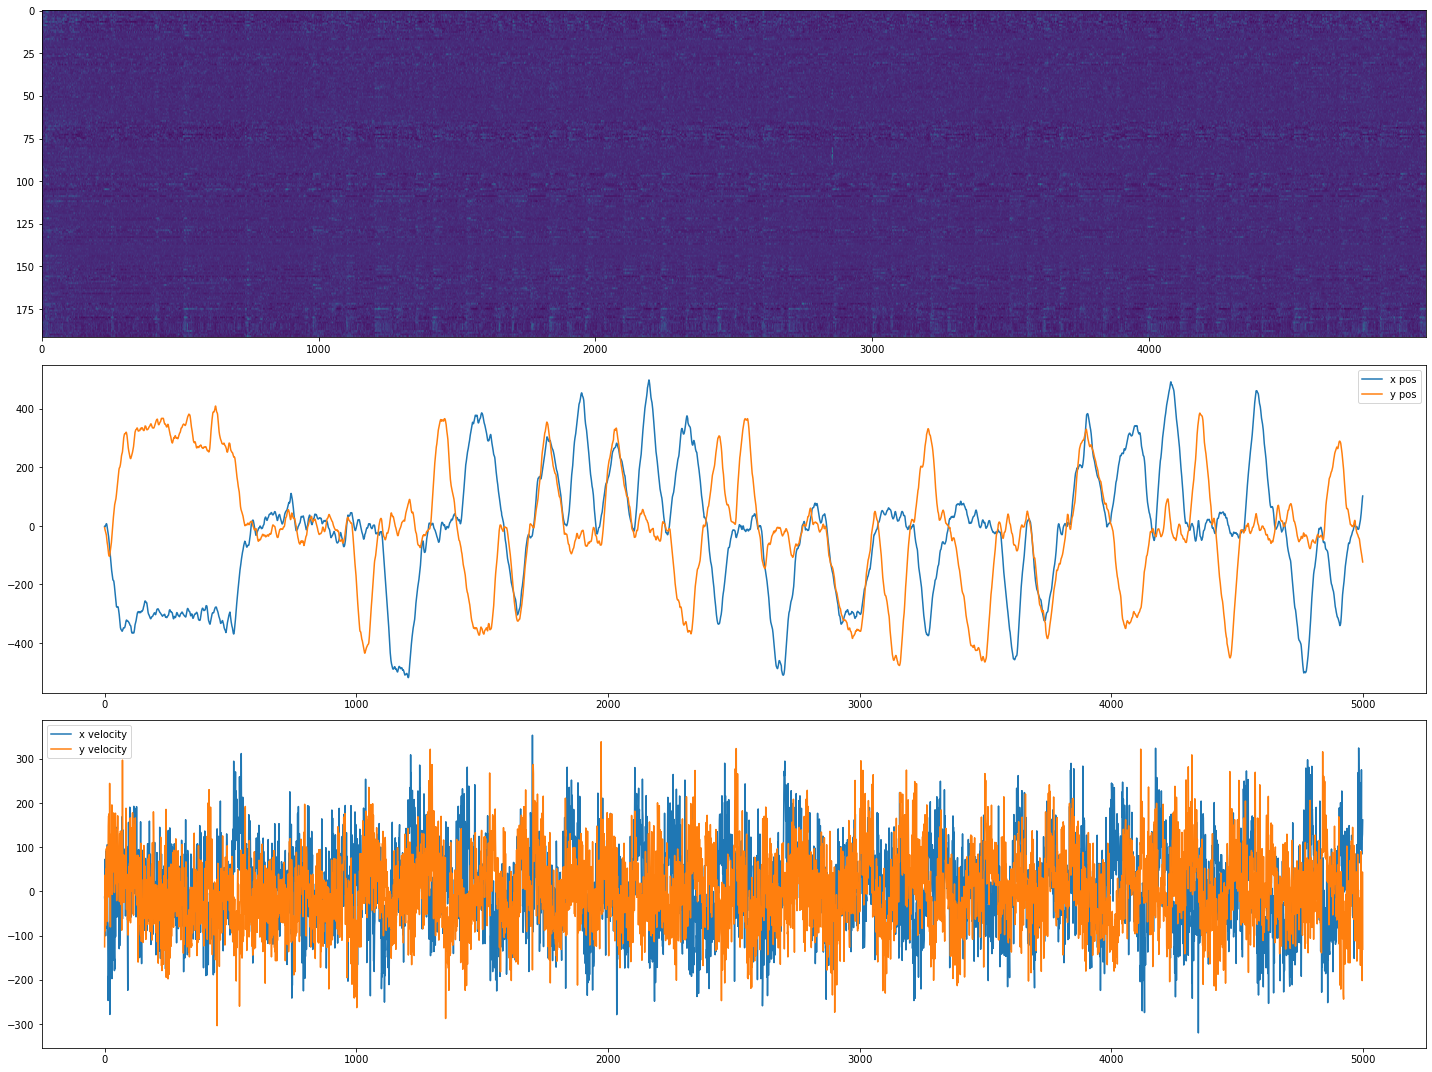

In [123]:
figSize(5 * 3, 20)

plt.subplot(311)
plt.imshow(neural[0][:5000, :].T, aspect = 'auto')

plt.subplot(312)
_ = plt.plot(cursorPos_flattened[:5000, 0], label = 'x pos')
_ = plt.plot(cursorPos_flattened[:5000, 1], label = 'y pos')
plt.legend()

plt.subplot(313)
_ = plt.plot(rawDecTraj[:5000, 0], label = 'x velocity')
_ = plt.plot(rawDecTraj[:5000, 1], label = 'y velocity')
plt.legend()

plt.tight_layout()

#plt.savefig(fig_path + 'HMM/T5example_cursorandneural', format = 'pdf')

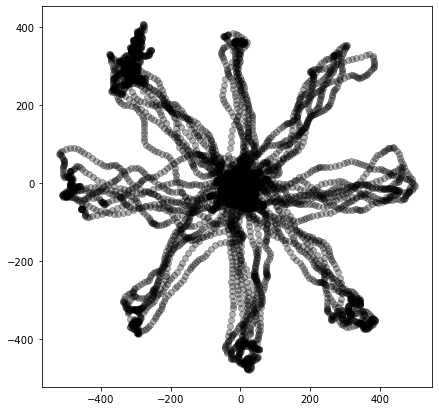

In [124]:
figSize(7, 7)
plt.scatter(cursorPos_flattened[:5000, 0], cursorPos_flattened[:5000, 1], color = 'k', alpha = 0.3)

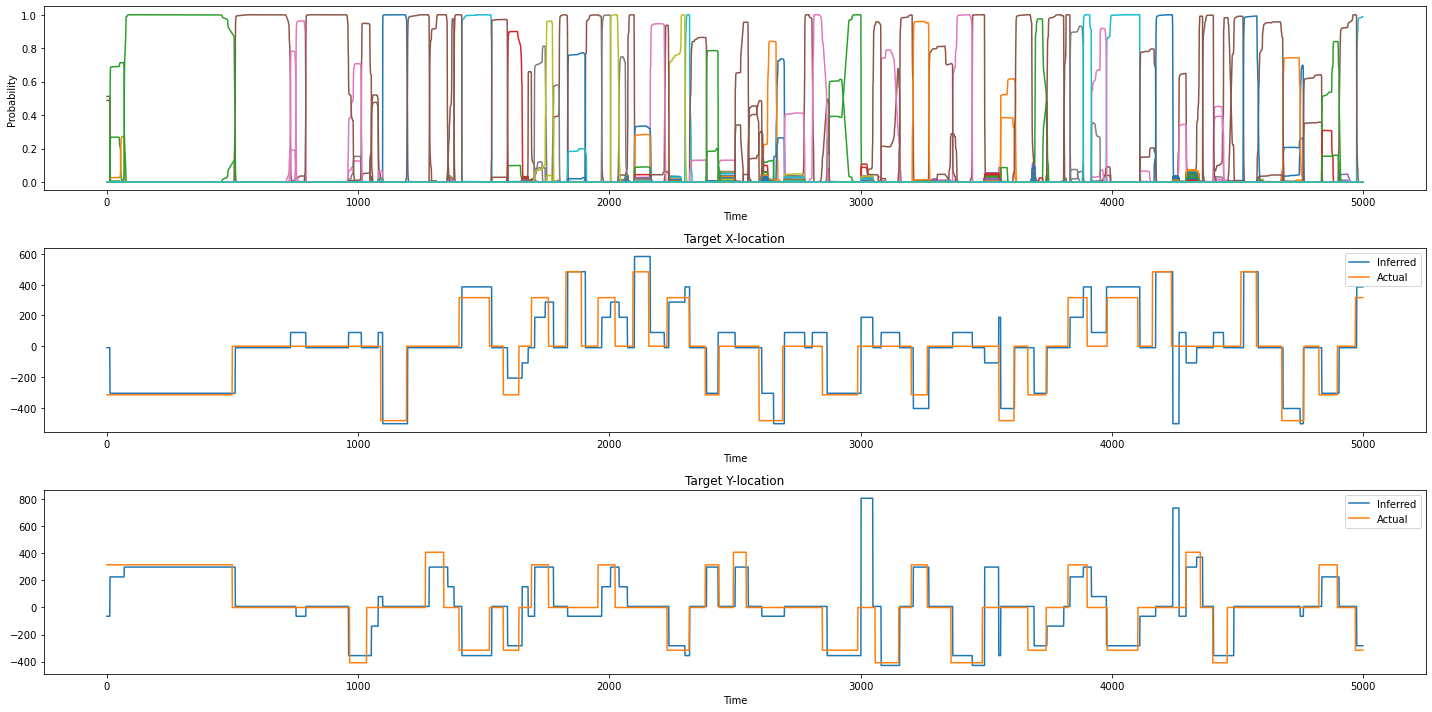

In [125]:
figSize(10, 20)


plt.subplot(3, 1, 1)
_ = plt.plot(pTargState[:, :5000].T)
plt.xlabel('Time')
plt.ylabel('Probability')

titles = ['Target X-location', 'Target Y-location']
for i in range(2):
    plt.subplot(3, 1, i+2)
    plt.plot(inferredTargLoc[:5000, i], label = 'Inferred')
    plt.plot((train_y + cursorPos)[0][:5000, i], label = 'Actual')
    plt.xlabel('Time')
    plt.legend()
    plt.title(titles[i])
plt.tight_layout()

#plt.savefig(fig_path + 'HMM/T5example_HMMOutput', format = 'pdf')

In [ ]:
# General parameters: 
train_frac    = 0.67
task          = None
sigma         = None
probThreshold = 'probWeighted'



# ---------------------------------------------------
date          = [day0.date]
models        = list()
scores        = np.zeros((5, 12)) # rows are 0 - no recalibration; 1 - mean recalibration; 2 - full recalibration; 3 - HMM recalibration (initial); 4 - HMM recalibration (each session)
scores[:, 0]  = ref_scores[0]

hmm_new_ref = deepcopy(ref_decoder)
for i in range(3, 14):
    file        = files[i]
    new_dat     = DataStruct(file, alignScreens = True)
    date.append(new_dat.date)
    
    train_x, test_x, train_y, test_y, cursorPos, _  = getTrainTest(new_dat, train_size = train_size, sigma = sigma, task = task, blocks = blocks, 
                                                               returnFlattened = True, returnCursor = True)
    
    train_x, test_x_MeanRecal = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    
    test_x          = np.concatenate(test_x)
    train_y         = np.concatenate(train_y)
    test_y          = np.concatenate(test_y)
    cursorPos       = np.concatenate(cursorPos)

    scores[0, i-2] = ref_decoder.score(test_x, test_y)                                                         # no recalibration
    scores[1, i-2] = ref_decoder.score(test_x_MeanRecal, test_y)                                               # mean recalibration
    scores[2, i-2] = LinearRegression(normalize = False).fit(train_x, train_y).score(test_x_MeanRecal, test_y) # full recalibration
    
    
    hmm_init_ref     = hmm.recalibrate(deepcopy(ref_decoder), [train_x], [cursorPos], probThreshold = probThreshold)
    hmm_new_ref      = hmm.recalibrate(hmm_new_ref, [train_x], [cursorPos], probThreshold = probThreshold)
    scores[3, i-2]   = hmm_init_ref.score(test_x_MeanRecal, test_y)
    scores[4, i-2]   = hmm_new_ref.score(test_x_MeanRecal, test_y)
   
    print(new_dat.date, ' finished')

In [ ]:
from preprocess import daysBetween
days = [daysBetween(day0.date, date[i]) for i in range(len(date))]


figSize(10, 20)

plt.subplot(1, 2, 1)
labels = ['No recalibration', 'Mean Recalibration', 'Full recalibration', 'HMM recalibration (init)', 'HMM recalibration (repeated)']
for i in range(5):
    plt.plot(days[:10], scores[i, :10].T, label = labels[i])

plt.ylim([-0.2, 0.6]) 
plt.xlabel('Days since reference session', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
plt.axhline(0, color = 'k', linestyle = '--', alpha  = 0.7)
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()

plt.savefig(fig_path + 'HMM/T5example_HMMtimestretch', format = 'pdf')

In [108]:
import numba

def adjustKappa(x):
    return np.ones(x.shape)

hmm = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa, adjustKappa)


start = time.time()
out_orig = hmm.decode(rawDecTraj[:50000, :], cursorPos[0][:50000, :])[0]
print('Original: ', time.time() - start)

start = time.time()
out_new = hmm.decode_numba(rawDecTraj[:50000, :], cursorPos[0][:50000, :])[0]
print('New: ', time.time() - start)

Original:  14.891188859939575
New:  9.21504259109497


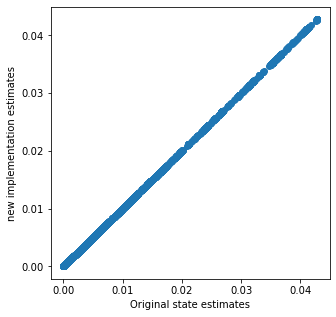

In [114]:
figSize(5, 5)
plt.scatter(out_orig[17, :], out_new[17, :])
plt.xlabel('Original state estimates')
plt.ylabel('new implementation estimates')

assert np.max(out_orig - out_new) < 1e-10, 'Not equivalent'